In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
from keras import optimizers

# from sklearn.cross_validation import KFold
from sklearn.metrics import fbeta_score
from sklearn.utils import shuffle

from keras.preprocessing.image import ImageDataGenerator


In [2]:
x_train = []
y_train = []

df_train = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
sample = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [5]:
df_test = sample[:40669]

df_test_extra = sample[40669:]

In [6]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

In [43]:
# labels

In [7]:
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (64, 64)))
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [02:11<00:00, 307.33it/s]


(40479, 64, 64, 3)
(40479, 17)


In [ ]:
# label_map

In [ ]:
# sample.iloc[40669, :]

In [ ]:
# sample.iloc[40668, :]

In [ ]:
# df_test = sample[:40669]
# print(df_test.shape)

In [ ]:
# df_test_extra = sample[40669:]
# df_test_extra.shape

In [ ]:
# df_test.head()

In [ ]:
# df_test_extra.head()

In [ ]:
# df_test.image_name.values

In [ ]:
# test_path1 = '../input/planets-dataset/planet/planet/test-jpg'
# test_path2 = '../input/planets-dataset/test-jpg-additional/test-jpg-additional'


# for x in Categories:
#     path2=os.path.join(Datadir2, x)
#     for img in os.listdir(path2):
#         img_array2= cv2.imread(os.path.join(path2,img), cv2.IMREAD_GRAYSCALE)

In [8]:
test = []
for f in tqdm(df_test.image_name.values, miniters=1000):
    img_test = cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(f))
    test.append(cv2.resize(img_test, (64, 64)))
    
for f in tqdm(df_test_extra.image_name.values, miniters=1000):
    img_test2 = cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(f))
    test.append(cv2.resize(img_test2, (64, 64)))
    
X_test = np.array(test, np.float16) / 255.

print(X_test.shape)


100%|██████████| 20522/20522 [01:12<00:00, 283.63it/s]


(61191, 64, 64, 3)


In [9]:
import numpy as np
from sklearn.metrics import fbeta_score

def optimise_f2_thresholds(y, p, verbose=True, resolution=100):
    def mf(x):
        p2 = np.zeros_like(p)
        for i in range(17):
            p2[:, i] = (p[:, i] > x[i]).astype(np.int)
        score = fbeta_score(y, p2, beta=2, average='samples')
        return score

    x = [0.2]*17
    for i in range(17):
        best_i2 = 0
        best_score = 0
        for i2 in range(resolution):
            i2 /= resolution
            x[i] = i2
            score = mf(x)
            if score > best_score:
                best_i2 = i2
                best_score = score
            
        x[i] = best_i2
        if verbose:
            print(i, best_i2, best_score)

    return x

In [10]:
split = 35000

x_train, x_valid, y_train, y_valid = x_train[:split], x_train[split:], y_train[:split], y_train[split:]


In [48]:
# image_gen = ImageDataGenerator(vertical_flip=True, zoom_range=0.2,
#     rotation_range=90,
#     fill_mode = 'reflect',
#     horizontal_flip=True)


## Model Architecture

## Model1

In [11]:
model1_weights_path = os.path.join('', 'my_model12_weights.h5')

model = Sequential()
model.add(BatchNormalization(input_shape=(64, 64, 3)))

model.add(Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(17, activation='sigmoid'))

## Model2

80142336/80134624 [==============================] - 1s 0us/step


## Model3

In [14]:
# model3_weights_path = os.path.join('', 'model3_weights.h5')

# from keras.applications.vgg16 import VGG16
# base_model3=VGG19(include_top=False,
#                weights='imagenet',
#                input_shape=(64, 64, 3))

# model3 = Sequential()
# model3.add(BatchNormalization(input_shape=(64, 64, 3)))
# model3.add(base_model3)
# model3.add(Flatten())
# # I don't use 4096 Dense layer because it might get higher score on LB.
# # Source: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/discussion/36091#202629
# #model.add(Dense(4096, activation='relu'))
# #model.add(Dense(4096, activation='relu'))
# model3.add(Dense(17, activation='sigmoid'))

In [ ]:
# modelplay_weights_path = os.path.join('', 'modelplay_weights.h5')

# model = Sequential()
# model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64,64,3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.3))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(17, activation='sigmoid'))

In [ ]:
# path

In [ ]:
# from keras.callbacks import ModelCheckpoint

# check = ModelCheckpoint(filepath='my_model.weight.best.hdf5', 
#                         monitor='val_acc', verbose=1, save_best_only=True, mode='max' )

In [12]:
from keras.callbacks import ReduceLROnPlateau

In [13]:
callbacks = [
            EarlyStopping(monitor='val_loss', patience=2, verbose=1, min_delta=1e-4),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
            ModelCheckpoint(model1_weights_path, monitor='val_loss', save_best_only=True, verbose=1)]



# callbacks3 = [
#             EarlyStopping(monitor='val_loss', patience=3, verbose=0),
#             ModelCheckpoint(model3_weights_path, monitor='val_loss', save_best_only=True, verbose=0)]

In [14]:
from keras.optimizers import Adam

In [15]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])



# model3.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [67]:
import gc
gc.collect()

1920

In [17]:
#x_valid

In [18]:
history = model.fit(x_train, y_train,batch_size=128, 
          validation_data=(x_valid, y_valid), epochs=30, verbose=2,callbacks=callbacks,shuffle=True)

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.50383, saving model to my_model12_weights.h5
274/274 - 9s - loss: 0.6017 - accuracy: 0.1062 - val_loss: 0.5038 - val_accuracy: 0.4514
Epoch 2/30

Epoch 00002: val_loss improved from 0.50383 to 0.26005, saving model to my_model12_weights.h5
274/274 - 8s - loss: 0.3359 - accuracy: 0.1813 - val_loss: 0.2601 - val_accuracy: 0.4731
Epoch 3/30

Epoch 00003: val_loss improved from 0.26005 to 0.18888, saving model to my_model12_weights.h5
274/274 - 8s - loss: 0.2027 - accuracy: 0.2304 - val_loss: 0.1889 - val_accuracy: 0.1712
Epoch 4/30

Epoch 00004: val_loss improved from 0.18888 to 0.17119, saving model to my_model12_weights.h5
274/274 - 8s - loss: 0.1677 - accuracy: 0.2934 - val_loss: 0.1712 - val_accuracy: 0.2356
Epoch 5/30

Epoch 00005: val_loss improved from 0.17119 to 0.16412, saving model to my_model12_weights.h5
274/274 - 8s - loss: 0.1534 - accuracy: 0.3605 - val_loss: 0.1641 - val_accuracy: 0.2993
Epoch 6/30

Epoch 00006: val_

In [23]:
# history2 = model2.fit_generator(image_gen.flow(x_train, y_train,batch_size=128),
#                               steps_per_epoch=x_train.shape[0]/128, 
#           validation_data=image_gen.flow(x_valid, y_valid, batch_size=128),
#                               validation_steps=x_valid.shape[0]/128, epochs=20,
#                               verbose=2,callbacks=callbacks,shuffle=True)

Epoch 1/20
547/546 - 69s - loss: 0.1431 - accuracy: 0.6319 - val_loss: 0.1203 - val_accuracy: 0.6227
Epoch 2/20
547/546 - 67s - loss: 0.1194 - accuracy: 0.6370 - val_loss: 0.1151 - val_accuracy: 0.6435
Epoch 3/20
547/546 - 67s - loss: 0.1137 - accuracy: 0.6431 - val_loss: 0.1093 - val_accuracy: 0.6569
Epoch 4/20
547/546 - 66s - loss: 0.1107 - accuracy: 0.6436 - val_loss: 0.1093 - val_accuracy: 0.6574
Epoch 5/20
547/546 - 66s - loss: 0.1089 - accuracy: 0.6428 - val_loss: 0.1087 - val_accuracy: 0.6280
Epoch 6/20
547/546 - 66s - loss: 0.1069 - accuracy: 0.6366 - val_loss: 0.1040 - val_accuracy: 0.6220
Epoch 7/20
547/546 - 66s - loss: 0.1061 - accuracy: 0.6406 - val_loss: 0.1074 - val_accuracy: 0.6532
Epoch 8/20
547/546 - 66s - loss: 0.1043 - accuracy: 0.6436 - val_loss: 0.1068 - val_accuracy: 0.6457
Epoch 9/20
547/546 - 66s - loss: 0.1033 - accuracy: 0.6437 - val_loss: 0.1057 - val_accuracy: 0.6594


In [24]:
gc.collect()

99

In [25]:
# history3 = model3.fit_generator(image_gen.flow(x_train, y_train,batch_size=128),
#                               steps_per_epoch=x_train.shape[0]/128, 
#           validation_data=image_gen.flow(x_valid, y_valid, batch_size=128),
#                               validation_steps=x_valid.shape[0]/128, epochs=20,
#                               verbose=2,callbacks=callbacks,shuffle=True)

Epoch 1/20
547/546 - 67s - loss: 0.1452 - accuracy: 0.6398 - val_loss: 0.1193 - val_accuracy: 0.6384
Epoch 2/20
547/546 - 67s - loss: 0.1192 - accuracy: 0.6456 - val_loss: 0.1141 - val_accuracy: 0.6335
Epoch 3/20
547/546 - 66s - loss: 0.1133 - accuracy: 0.6455 - val_loss: 0.1154 - val_accuracy: 0.6691
Epoch 4/20
547/546 - 65s - loss: 0.1111 - accuracy: 0.6482 - val_loss: 0.1098 - val_accuracy: 0.6824
Epoch 5/20
547/546 - 66s - loss: 0.1080 - accuracy: 0.6467 - val_loss: 0.1076 - val_accuracy: 0.6556
Epoch 6/20
547/546 - 66s - loss: 0.1065 - accuracy: 0.6483 - val_loss: 0.1086 - val_accuracy: 0.6346
Epoch 7/20
547/546 - 66s - loss: 0.1053 - accuracy: 0.6477 - val_loss: 0.1074 - val_accuracy: 0.6231
Epoch 8/20
547/546 - 67s - loss: 0.1044 - accuracy: 0.6491 - val_loss: 0.1029 - val_accuracy: 0.6279
Epoch 9/20
547/546 - 66s - loss: 0.1033 - accuracy: 0.6425 - val_loss: 0.1055 - val_accuracy: 0.6561
Epoch 10/20
547/546 - 66s - loss: 0.1024 - accuracy: 0.6506 - val_loss: 0.1052 - val_accura

In [23]:
del x_train, y_train

gc.collect()

28

Text(0.5, 1.0, 'Loss Curves - With Reularization - Model1')

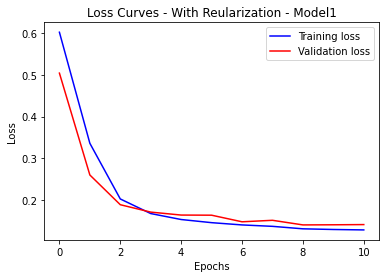

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], 'blue')
plt.plot(history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - With Reularization - Model1')

Text(0.5, 1.0, 'Loss Curves - With Reularization - Model2')

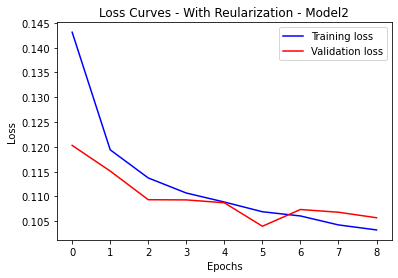

Text(0.5, 1.0, 'Loss Curves - With Reularization - Model3')

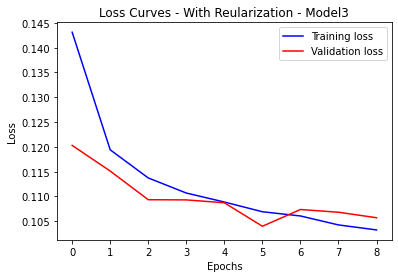

In [29]:
plt.figure()
plt.plot(history2.history['loss'], 'blue')
plt.plot(history2.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - With Reularization - Model3')

In [24]:
from sklearn.metrics import fbeta_score

In [20]:
# model.load_weights(model1_weights_path)
p_valid = model.predict(x_valid, batch_size = 128, verbose=2)
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))
print("Optimizing prediction threshold for model 1")
print(optimise_f2_thresholds(y_valid, p_valid))

43/43 - 0s
0.8611876370959111
Optimizing prediction threshold for model 1
0 0.12 0.861563086841224
1 0.21 0.861603782774577
2 0.03 0.8621039393548019
3 0.07 0.8621039393548019
4 0.12 0.8624872749877722
5 0.11 0.8635799019994519
6 0.09 0.8642212399638682
7 0.02 0.8727456702192121
8 0.33 0.8731846083977012
9 0.03 0.8731846083977012
10 0.04 0.8731846083977012
11 0.12 0.8751042399242241
12 0.19 0.8753554095511353
13 0.05 0.8754726071896486
14 0.08 0.8756203970578161
15 0.12 0.8762175747367281
16 0.07 0.8762175747367281
[0.12, 0.21, 0.03, 0.07, 0.12, 0.11, 0.09, 0.02, 0.33, 0.03, 0.04, 0.12, 0.19, 0.05, 0.08, 0.12, 0.07]


In [27]:
# model3 = model.load_weights(model3_weights_path)
# p_valid3 = model3.predict(x_valid, batch_size = 64, verbose=2)
# print(fbeta_score(y_valid, np.array(p_valid3) > 0.2, beta=2, average='samples'))
# print("Optimizing prediction threshold for model3")
# print(optimise_f2_thresholds(y_valid, p_valid3))

43/43 - 1s
0.8940666766229154
Optimizing prediction threshold for model3
0 0.14 0.8945043832159392
1 0.07 0.8954660385114444
2 0.12 0.8955072777842952
3 0.02 0.8963886054376619
4 0.09 0.896822324977939
5 0.09 0.8970180022396819
6 0.08 0.8983287957027949
7 0.28 0.8984022548489644
8 0.09 0.898447674870509
9 0.2 0.898447674870509
10 0.04 0.8986729578437848
11 0.38 0.8986841532620354
12 0.01 0.8995205962281759
13 0.99 0.899581593380086
14 0.1 0.9006399765236108
15 0.52 0.900717183732954
16 0.1 0.901349342994223
[0.14, 0.07, 0.12, 0.02, 0.09, 0.09, 0.08, 0.28, 0.09, 0.2, 0.04, 0.38, 0.01, 0.99, 0.1, 0.52, 0.1]


In [ ]:
gc.collect()

In [ ]:
# # sample.head()
# # serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")
 
# # later...
 
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

# weight_path = os.path.join('', '../h5_128_rotate_uint8/weights_kfold_' + str(num_fold) + '.h5')

In [21]:
pred = model.predict(X_test, batch_size=128)

In [ ]:
# pred3 = model3.predict(X_test, batch_size=64)

In [ ]:
# pred

In [22]:
full_test = []
full_test.append(pred)
result = np.array(full_test[0])
result = pd.DataFrame(result, columns = labels)
result.head()

,partly_cloudy,habitation,artisinal_mine,blooming,road,agriculture,bare_ground,cloudy,primary,blow_down,slash_burn,water,cultivation,selective_logging,clear,haze,conventional_mine
0,0.002749,0.002138,0.002251,0.008632,0.006695,0.012469,0.001946,0.003308,0.996780,0.002872,0.002098,0.014674,0.006670,0.002959,0.991288,0.007012,0.001427
1,0.007360,0.006617,0.005040,0.024794,0.017705,0.043711,0.004721,0.004571,0.996802,0.008943,0.006549,0.035141,0.038153,0.012552,0.992308,0.005210,0.003385
2,0.982891,0.009628,0.001851,0.001550,0.039620,0.110933,0.003937,0.010155,0.990672,0.002403,0.002338,0.112053,0.029191,0.001844,0.005993,0.003453,0.002413
3,0.042925,0.006867,0.003955,0.014508,0.018536,0.071426,0.005158,0.006096,0.995288,0.006636,0.005325,0.042542,0.049849,0.007302,0.921058,0.016028,0.003446
4,0.845130,0.011265,0.002683,0.001535,0.054054,0.088026,0.004143,0.156277,0.800882,0.003000,0.002202,0.074858,0.015974,0.001130,0.005019,0.006028,0.003211


In [ ]:
# full_test3 = []
# full_test3.append(pred3)
# result3 = np.array(full_test3[0])
# result3 = pd.DataFrame(result3, columns = labels)
# result3.head()

In [28]:
thres = [0.12, 0.21, 0.03, 0.07, 0.12, 0.11, 0.09, 0.02, 0.33, 0.03, 0.04, 0.12, 0.19, 0.05, 0.08, 0.12, 0.07]
prediction = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.loc[[i]]
    a = a.apply(lambda x: x > thres, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    prediction.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [02:25<00:00, 421.02it/s]


In [ ]:
# thres3 = [0.14, 0.07, 0.12, 0.02, 0.09, 0.09, 0.08, 0.28, 0.09, 0.2, 0.04, 0.38, 0.01, 0.99, 0.1, 0.52, 0.1]
# prediction3 = []
# for i in tqdm(range(result3.shape[0]), miniters=1000):
#     a3 = result3.loc[[i]]
#     a3 = a3.apply(lambda x: x > thres2, axis=1)
#     a3 = a3.transpose()
#     a3 = a3.loc[a3[i] == True]
#     ' '.join(list(a3.index))
#     prediction3.append(' '.join(list(a3.index)))

In [29]:
df1 = sample.copy()

# df3 = sample.copy()

In [30]:
df1['tags'] = prediction
df1.head()

,image_name,tags
0,test_0,water blooming artisinal_mine clear
1,test_1,water blooming agriculture road artisinal_mine...
2,test_2,water agriculture partly_cloudy road artisinal...
3,test_3,blooming artisinal_mine clear
4,test_4,water blooming agriculture partly_cloudy road ...


In [ ]:
# df3['tags'] = prediction3
# df3.head()

In [ ]:
# fig = plt.figure(figsize=(20, 8))
# for i, idx in enumerate(np.random.choice(x_valid.shape[0], size=32, replace=False)):
#     ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
#     ax.imshow(np.squeeze(x_valid[idx]))
#     pred_idx = np.argmax(pred_valid[idx])
#     true_idx = np.argmax(y_valid[idx])
#     ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
#                  color=("green" if pred_idx == true_idx else "red"))

In [31]:
df1.to_csv('new_sub1.csv', index=False)

In [ ]:
# df3.to_csv('new_sub3.csv', index=False)

In [ ]:
import os
os.chdir(r'kaggle/working')

In [ ]:
sample.to_csv(r'my_kaggle_submission.csv', index=False)

In [ ]:
from IPython.display import FileLink
FileLink(r'my_kaggle_submission.csv')